### QC+ for Cai 2020 dataset

#### Objective: Run advanced QC for the Cai 2020 dataset, including data normalization, log transformation, and UMAP visualization


**Developed by**: Mairi McClean

**Affiliation**: Institute of Computational Biology - Computational Health Centre - Helmholtz Munich

**v221130**


### Load modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
import igraph as ig
from matplotlib import colors
from matplotlib import rcParams

#### Log file and figure output settings

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.2.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cffi                1.15.1
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
entrypoints         0.4
executing           1.1.1
google              NA
h5py                3.6.0
hypergeom_ufunc     NA
igraph              0.10.2
ipykernel           6.16.2
ipywidgets          8.0.2
jedi                0.18.1
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.0
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.6.1
mpl_toolkits        NA
natsort             8.2.0
nbinom_ufunc        NA
ncf_ufunc           NA
numba               0.56.3
numexpr             2.8.1
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso       

### Read in anndata object

In [4]:
adata = sc.read_h5ad('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qcd_objects/0512_0912_exported_objects/06/CaiY2022_TB_PBMC_QCed_pre-process_mm221206.h5ad')
adata

AnnData object with n_obs × n_vars = 98563 × 61533
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'age', 'gender', 'status', 'batch', 'datasets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors'
    layers: 'counts', 'sqrt_norm'

### Data normalization

target_sum taken from Scanpy tutorial [https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html]

If exclude_highly_expressed=True, very highly expressed genes are excluded from the computation of the normalization factor (size factor) for each cell. 
> This is meaningful as these can strongly influence the resulting normalized values for all other genes [Weinreb17]."

1e4 changed to 1e6; option to exclude highly expressed genes, set as true - CHANGE THIS FIRST before changing any other variable to observe effects on PCA output


In [5]:
sc.pp.normalize_total(adata, target_sum=1e6, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)


### Data log transformation

In [6]:
sc.pp.log1p(adata)

### Identify highly variable genes

Code from Carlos' notebook scVI_exploratory_analysis; Seurat should be used for all generative models
Number of genes (top_genes) based on how mixed the sample is, and computational power. Highest gene number is 10,000
Batch_key is related to the data that we want to perform the filtering on
Carlos runs between 4000 (low RAM) and 7000
subset = True will remove all non-variable genes

In [7]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 8000,
    layer = "counts",
    batch_key = "sample",
    subset = True
)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [8]:
adata.var.head()


gene_id     mt   ribo  n_cells_by_counts  \
DDX11L1           ENSG00000223972.5  False  False                  9   
OR4G11P           ENSG00000240361.2  False  False                  4   
ENSG00000286448   ENSG00000286448.1  False  False                  6   
ENSG00000230021  ENSG00000230021.10  False  False               7173   
MTND1P23          ENSG00000225972.1  False  False               8896   

                 mean_counts  pct_dropout_by_counts  total_counts  \
DDX11L1             0.000101              99.990869          10.0   
OR4G11P             0.000051              99.995942           5.0   
ENSG00000286448     0.000061              99.993913           6.0   
ENSG00000230021     0.093433              92.722421        9209.0   
MTND1P23            0.135872              90.974301       13392.0   

                 highly_variable  highly_variable_rank     means  variances  \
DDX11L1                     True                1030.5  0.000647   0.004696   
OR4G11P                     True                2388.5  0.000325   0.002606   
ENSG00000286448             True                1007.0  0.000440   0.003311   
ENSG00000230021             True                 139.5  0.556484   4.006061   
MTND1P23                    True                2419.5  0.533045   2.897210   

                 variances_norm  highly_variable_nbatches  
DDX11L1                0.597173                         2  
OR4G11P                0.173117                         2  
ENSG00000286448        0.408957                         1  
ENSG00000230021        1.048637                         4  
MTND1P23               0.948155                         2

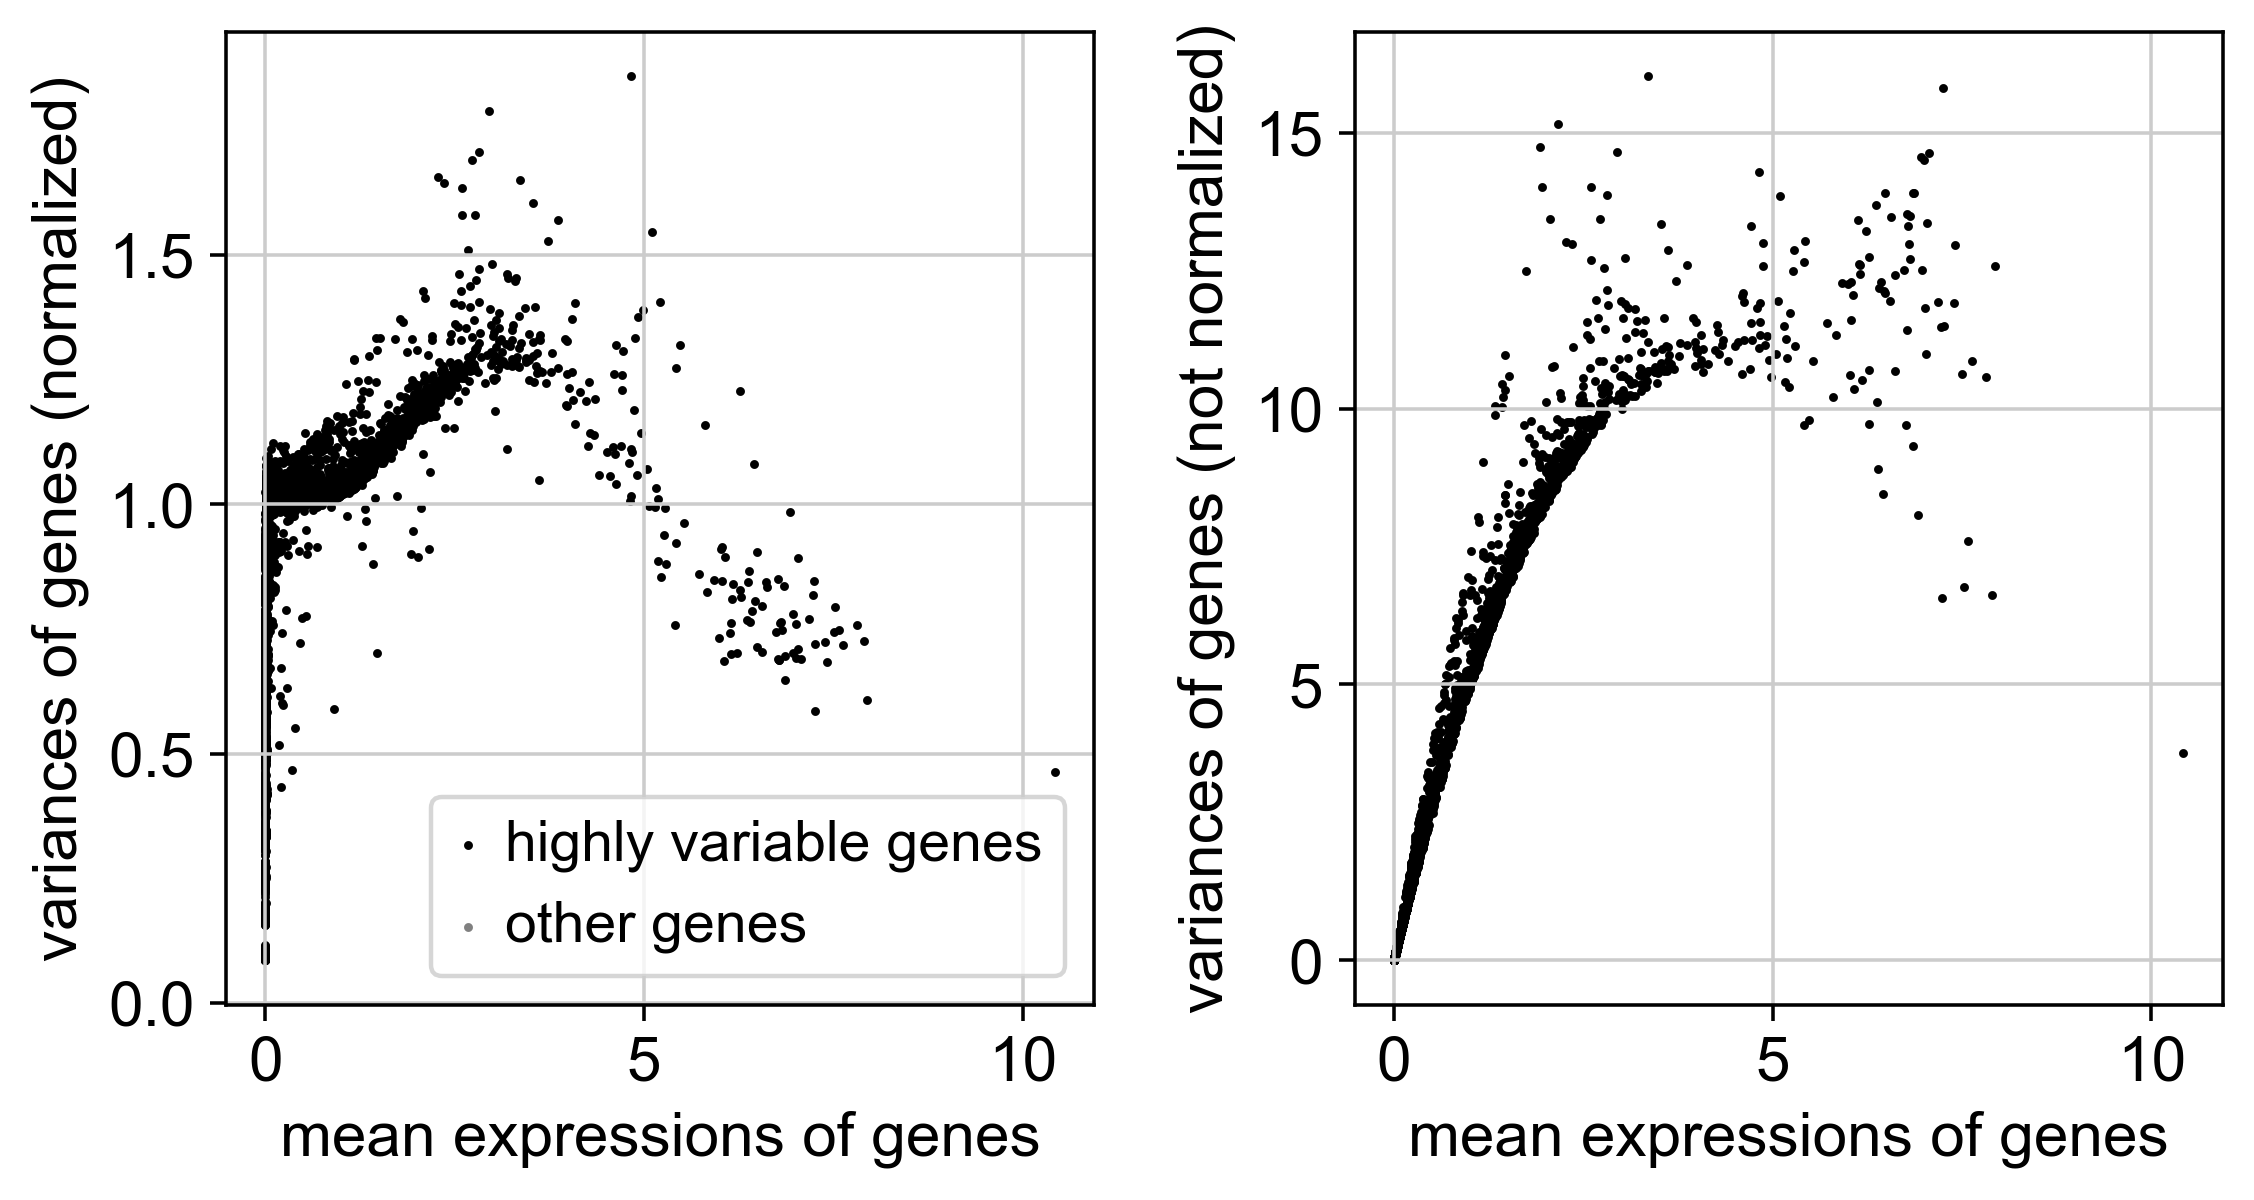

In [9]:
sc.pl.highly_variable_genes(adata)


We want to see between 0.25 and 0.75 after 1
This particular pattern either means that the data is garbage or that it is highly significant, caused by disease
Could see if changing the number of genes from between 4000 to 7000

### PCA

In [10]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)


In [11]:
adata

AnnData object with n_obs × n_vars = 98563 × 8000
    obs: 'study', 'individual', 'sample', 'tissue', 'donor', 'data_type', 'centre', 'version', 'object', 'protocol', 'age', 'gender', 'status', 'batch', 'datasets', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'gene_id', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'donor_colors', 'sample_colors', 'tissue_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'sqrt_norm'

Can add covariates here below; can remove frames from image

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


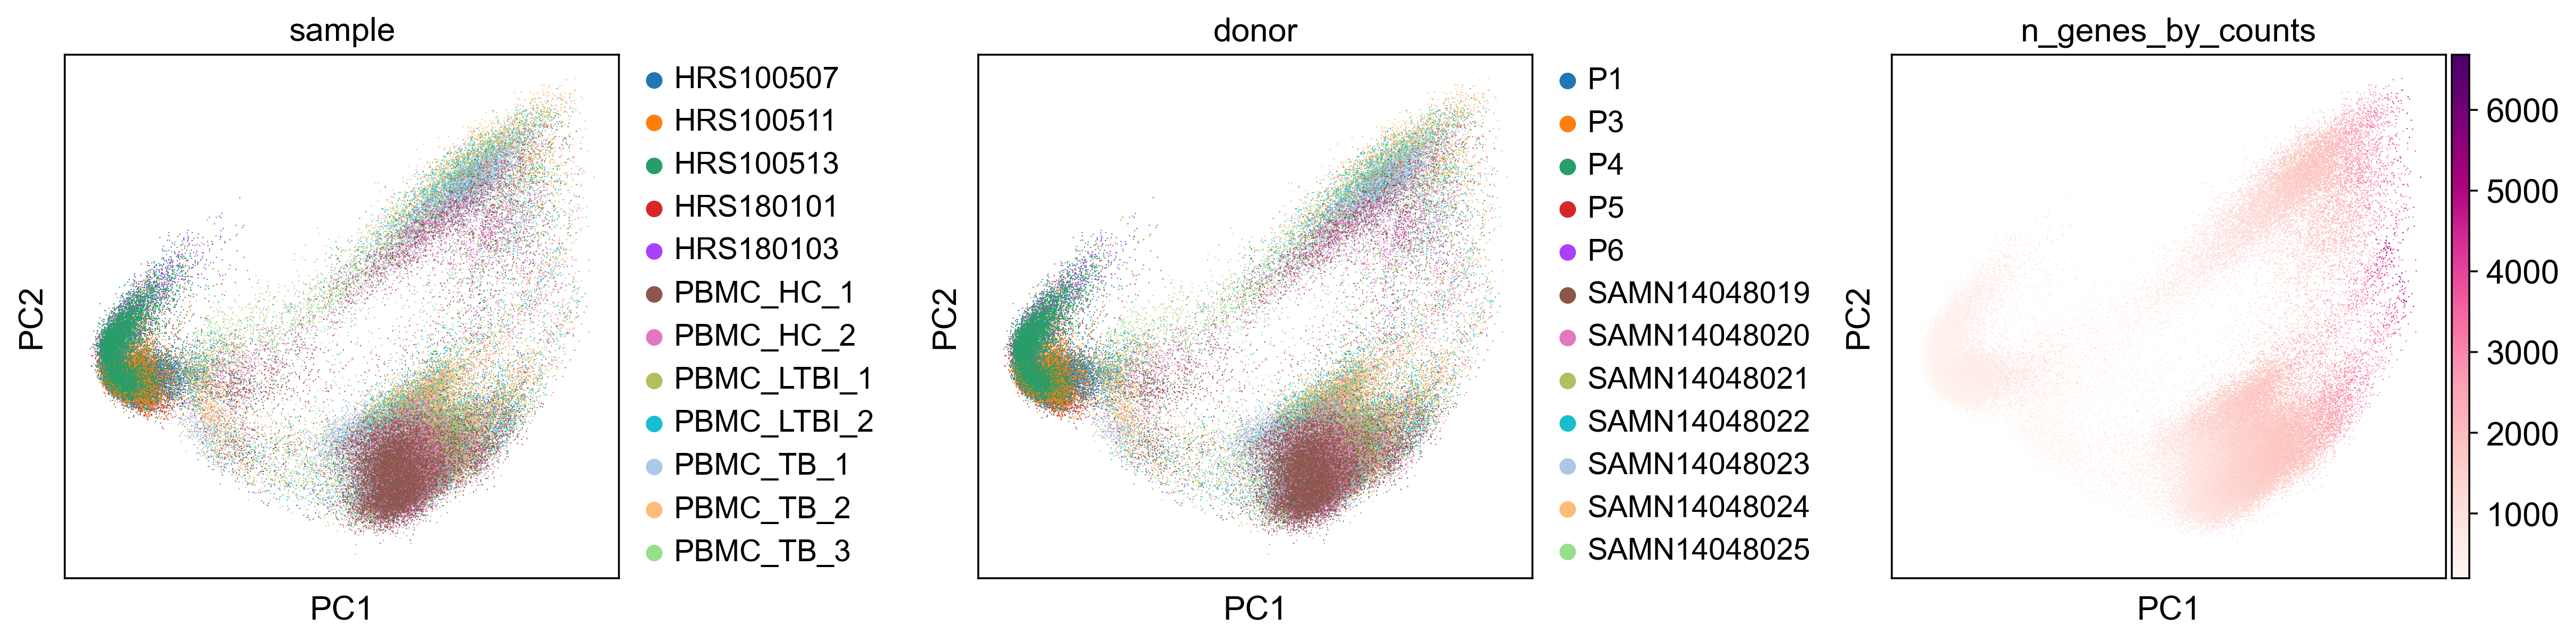

In [12]:
sc.pl.pca(adata, color = ['sample', 'donor', 'n_genes_by_counts'], wspace=0.5)

### Computing neighbourhood graph

Carlos chooses 50 neighbours, and 50 PCs (PCs used to be taken from elbow graph)

This step is done to create a 'scaffold' of the data; UMAP embedding will then place data over scaffold to see how it fits

In [13]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)



computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


### UMAP embedding

#### Clustering

In [14]:
# added to avoid error arising from running subsequent cell on its own

sc.tl.leiden(adata)

running Leiden clustering
    finished: found 24 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:23)


In [15]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:00)


In [16]:
adata.var.head()


gene_id     mt   ribo  n_cells_by_counts  \
DDX11L1           ENSG00000223972.5  False  False                  9   
OR4G11P           ENSG00000240361.2  False  False                  4   
ENSG00000286448   ENSG00000286448.1  False  False                  6   
ENSG00000230021  ENSG00000230021.10  False  False               7173   
MTND1P23          ENSG00000225972.1  False  False               8896   

                 mean_counts  pct_dropout_by_counts  total_counts  \
DDX11L1             0.000101              99.990869          10.0   
OR4G11P             0.000051              99.995942           5.0   
ENSG00000286448     0.000061              99.993913           6.0   
ENSG00000230021     0.093433              92.722421        9209.0   
MTND1P23            0.135872              90.974301       13392.0   

                 highly_variable  highly_variable_rank     means  variances  \
DDX11L1                     True                1030.5  0.000647   0.004696   
OR4G11P                     True                2388.5  0.000325   0.002606   
ENSG00000286448             True                1007.0  0.000440   0.003311   
ENSG00000230021             True                 139.5  0.556484   4.006061   
MTND1P23                    True                2419.5  0.533045   2.897210   

                 variances_norm  highly_variable_nbatches  
DDX11L1                0.597173                         2  
OR4G11P                0.173117                         2  
ENSG00000286448        0.408957                         1  
ENSG00000230021        1.048637                         4  
MTND1P23               0.948155                         2

In [17]:
adata.obs.head()

study individual  \
barcode                                                                    
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...  CaiY_2022  HRI111687   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...  CaiY_2022  HRI111687   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...  CaiY_2022  HRI111687   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...  CaiY_2022  HRI111687   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...  CaiY_2022  HRI111687   

                                                       sample tissue donor  \
barcode                                                                      
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...  HRS180101   PBMC    P5   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...  HRS180101   PBMC    P5   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...  HRS180101   PBMC    P5   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...  HRS180101   PBMC    P5   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...  HRS180101   PBMC    P5   

                                                   data_type  \
barcode                                                        
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...  scRNAseq   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...  scRNAseq   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...  scRNAseq   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...  scRNAseq   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...  scRNAseq   

                                                                 centre  \
barcode                                                                   
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...  Shenzhen University   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...  Shenzhen University   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...  Shenzhen University   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...  Shenzhen University   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...  Shenzhen University   

                                                   version     object  \
barcode                                                                 
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...   10XV2  HRS180101   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...   10XV2  HRS180101   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...   10XV2  HRS180101   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...   10XV2  HRS180101   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...   10XV2  HRS180101   

                                                         protocol  ...  \
barcode                                                            ...   
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...  pbmc_scRNAseq  ...   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...  pbmc_scRNAseq  ...   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...  pbmc_scRNAseq  ...   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...  pbmc_scRNAseq  ...   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...  pbmc_scRNAseq  ...   

                                                   total_counts_ribo  \
barcode                                                                
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...               6.0   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...              19.0   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...               3.0   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...              11.0   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonecai...              17.0   

                                                   pct_counts_ribo  \
barcode                                                              
AAACCTGGTATAGGGC-HRS180101-pbmc_scRNAseqnonecai...        1.492537   
AAACCTGTCTTTAGTC-HRS180101-pbmc_scRNAseqnonecai...        4.513064   
AAACGGGAGTTAACGA-HRS180101-pbmc_scRNAseqnonecai...        0.961538   
AAAGATGAGCAGACTG-HRS180101-pbmc_scRNAseqnonecai...        2.558140   
AAAGATGAGGACGAAA-HRS180101-pbmc_scRNAseqnonec

/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


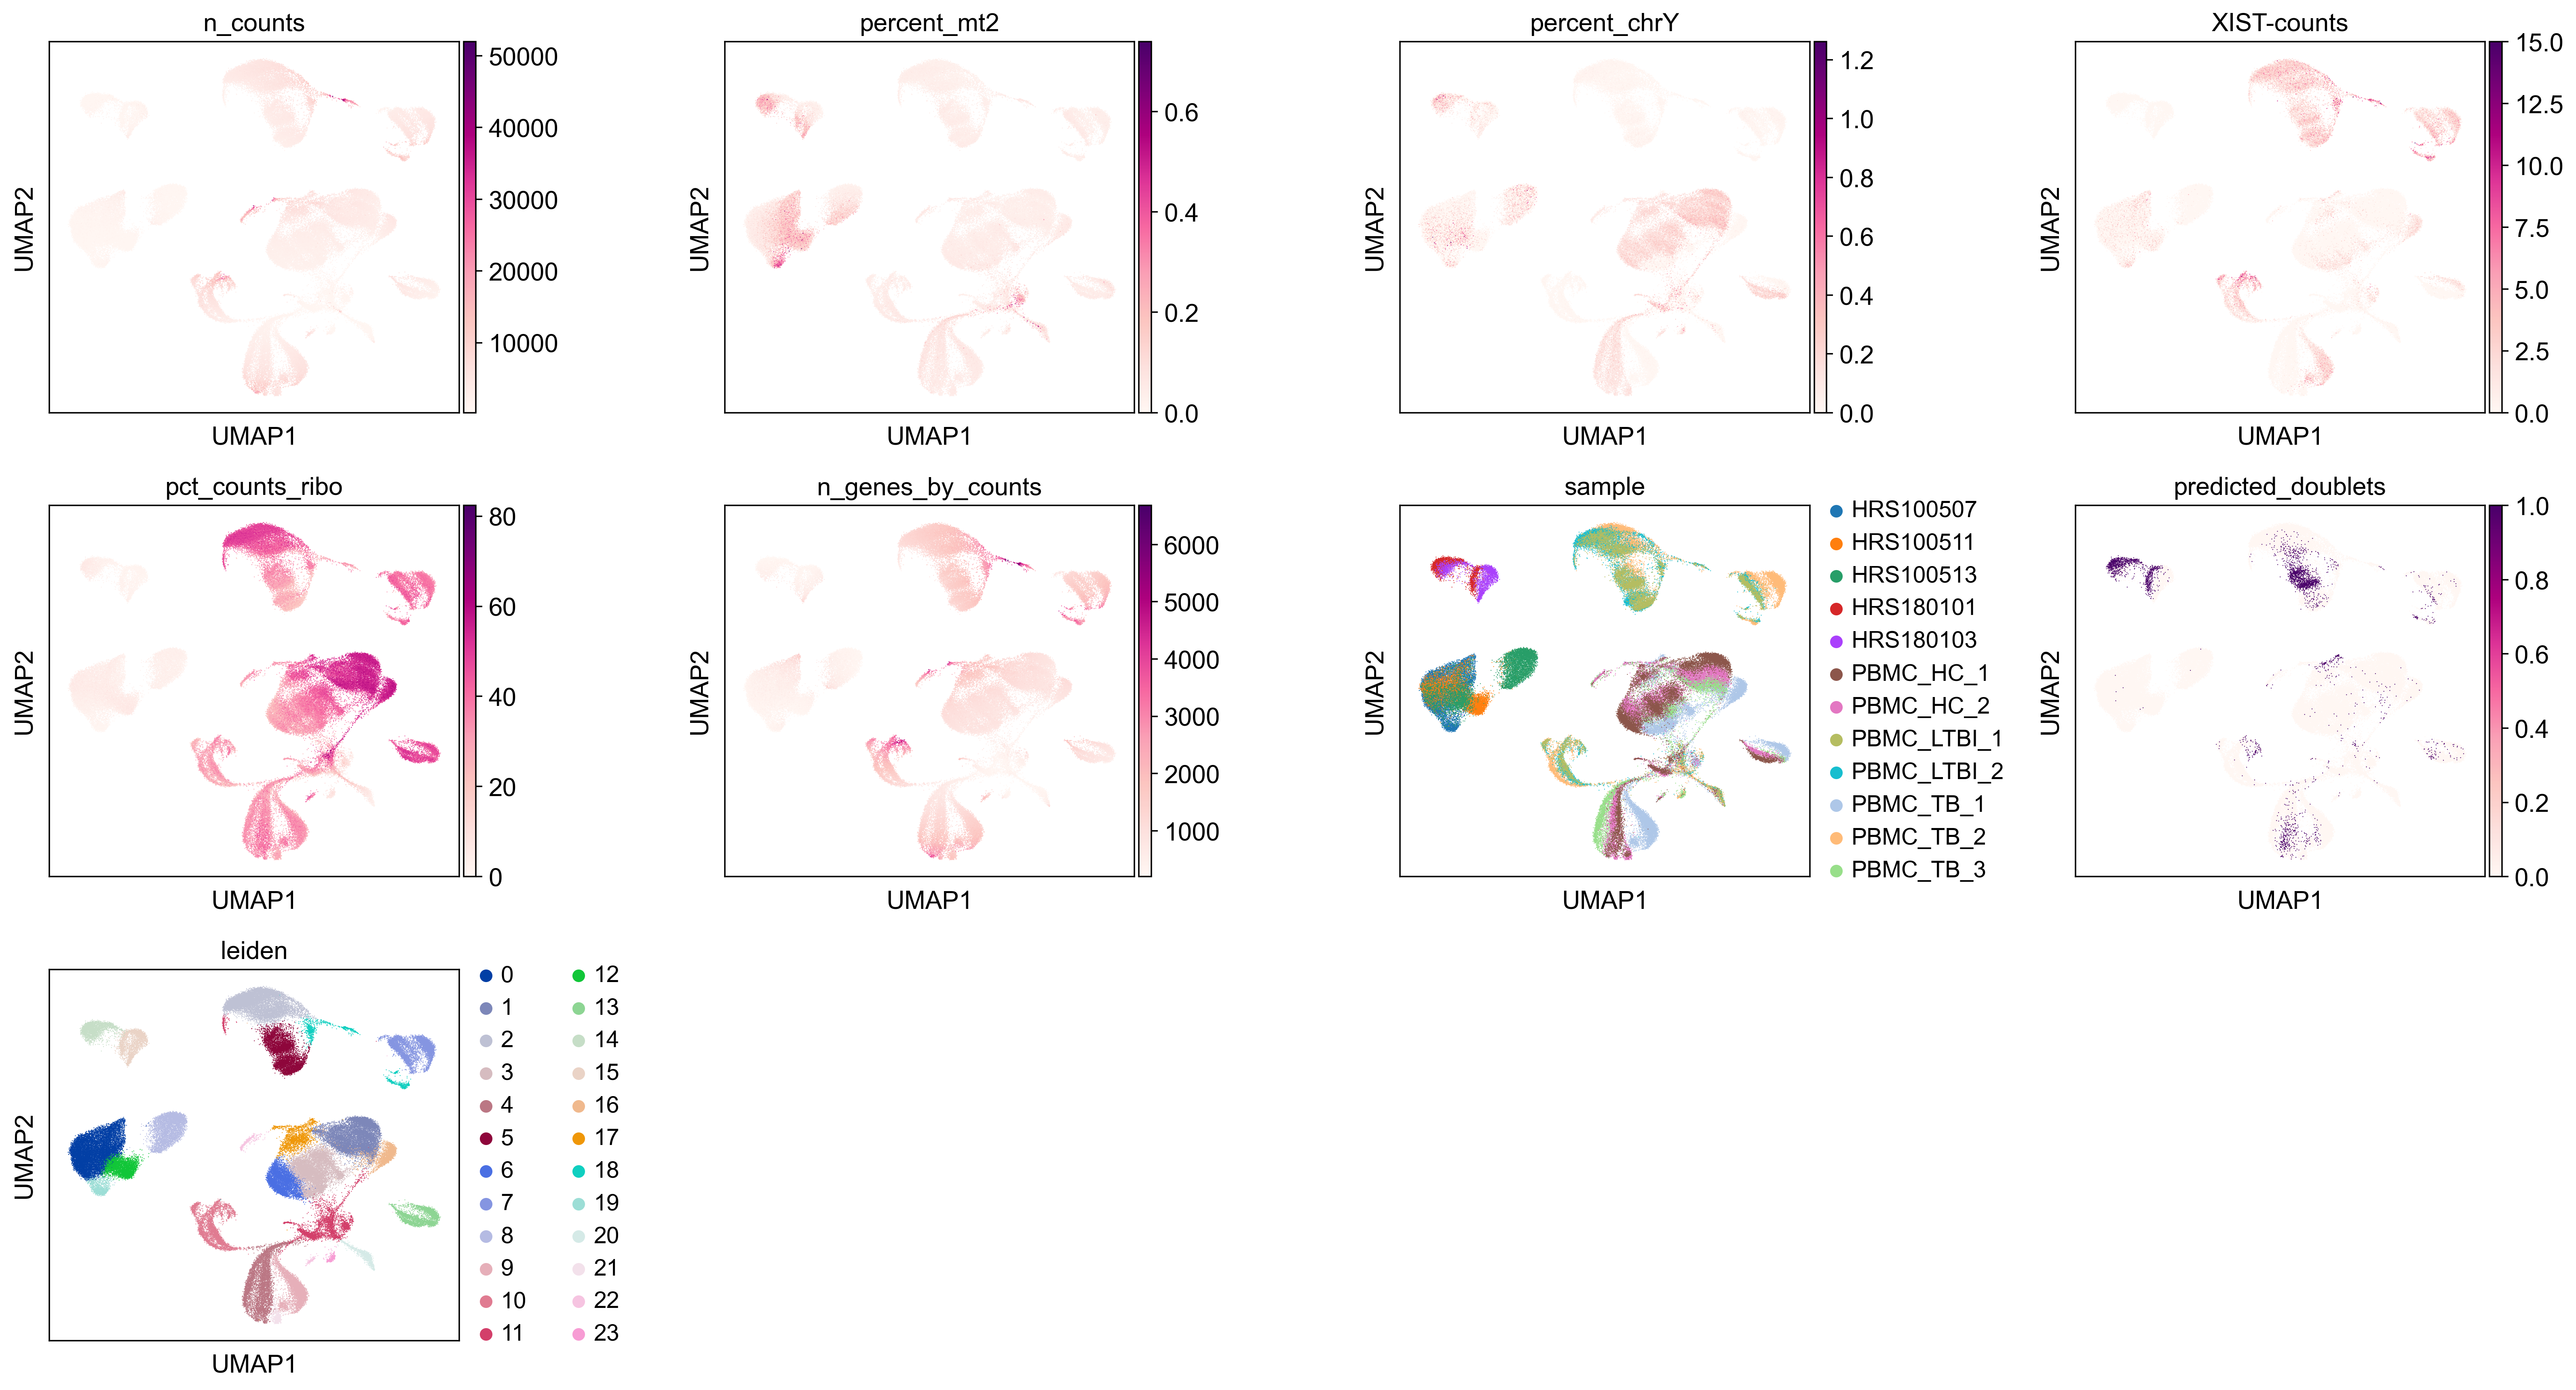

In [19]:
sc.pl.umap(adata, color=[     
    'n_counts', 
    'percent_mt2',  
    'percent_chrY', 
    'XIST-counts',  
    'pct_counts_ribo',  
    'n_genes_by_counts', 
    'sample',   
    'predicted_doublets',   
    'leiden'], size = 1,   
    wspace=0.50)

In [ ]:
# Each sample has made it's own cluster, which is batch effect
# choose variety of covariates from obs for panel

In [ ]:
# Now we can use the following code to plot the scaled and corrected gene expression data

sc.pl.umap(adata, use_raw=False, )

### Writing out object


In [ ]:
adata.write('/Users/mairi.mcclean/github/data/tb_pbmc_datasets/qc_plus_visualisation/221201_PBMC_CaiY2022_MM_UMAP_v221206.h5ad')
# needs extension .h5ad